In [2]:
### This is a gene specific analysis notebook
import pickle, os
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

In [3]:
# output directory
dir_out_figure = '../manuscript/figures_data/'

if not os.path.exists(dir_out_figure):
    os.makedirs(dir_out_figure)

In [4]:
#-------------Read Data------------------
# Read expression data
exp_dir = '../data/anno_refs/pcawg_rnaseq/'
gene_tophat = 'tophat_star_fpkm.v2.aliquot_gl.tsv'
# Read aliquot id information
df_exp_info = pd.read_csv(os.path.join(exp_dir,'rnaseq.metadata.tsv'), sep = '\t')
# Read expression information
df_exp = pd.read_csv(os.path.join(exp_dir,gene_tophat),sep = '\t', index_col = 0)

In [5]:
# Read the synonymous candidate dataframe
dir_out_fig4 = './figure4/'
feature_type = 'histology';syn_nsyn = 'syn';run = 'cohort_new_newcova_nohypermutator'
df_syn = pd.read_csv(os.path.join(dir_out_fig4,feature_type+'.syn.df_all_forheatmap.'+run+'.csv'),index_col = 0)
df_syn = df_syn.set_index('gene')

# Read the significant gene-id dataframe
fsig_name = 'sig_gene_name_id.csv'
df_nsig = pd.read_csv(os.path.join(dir_out_fig4, fsig_name))
df_nsig.columns = ['name', 'id']

dir_maf = '../data/maf/histology_nohypermutator'

In [6]:
#-------------Syn Patient Expression------------------
def get_gene_exp(gene_name, df_expression):
    global df_nsig
    idx = df_nsig[df_nsig['name'] == gene_name].index
    gene_id = df_nsig.loc[idx, 'id'].values[0]
    df = df_expression.loc[df_expression.index.str.contains(rf'{gene_id}'),:]
    return df

def get_syn_mut(gene_name):
    global df_syn
    histology = df_syn.loc[gene_name,'feature']
    df_maf = pd.read_csv(os.path.join(dir_maf, histology+'.csv'), sep = '\t')
    df_maf = df_maf.set_index(['Hugo_Symbol','Variant_Classification','Donor_ID' ])
    df_mut = df_maf.loc[pd.IndexSlice[gene_name, :,:],:]
    df_silent = df_maf.loc[pd.IndexSlice[gene_name, 'Silent',:],:]
    patient = df_silent.index.get_level_values('Donor_ID').unique().tolist()
    
    return df_mut, df_silent, patient

def get_patient_id(gene_name, patients):
    global df_exp_info, df_syn
    histology = df_syn.loc[gene_name,'feature']
    df = df_exp_info[df_exp_info['histology_abbreviation'] == histology]
    
    # Get tumor, syn and normal patient aliquot id
    normal_id = df[df['tumor.normal'] == 'normal']['aliquot_id']
    df_tumor = df[df['tumor.normal'] == 'tumor']
    tumor_syn_id = df_tumor[df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    tumor_other_id = df_tumor[~df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    
    return normal_id, tumor_syn_id, tumor_other_id

def get_patient_exp(ids, df_gene_exp, tissue_type = None):
    df_for_test = df_gene_exp[ids].transpose()
    df = df_gene_exp[ids].transpose().reset_index()
    df['tumor.normal'] = tissue_type
    df.columns = ['id','exp','tumor.normal']
    
    return df, df_for_test

In [7]:
def get_expression(gene):
    histology = df_syn.loc[gene,'feature']

    df_exp_gene = get_gene_exp(gene, df_exp)
    df_allmut, df_synmut, synp = get_syn_mut(gene)
    id_normal, id_syn, id_other =get_patient_id(gene, synp)

    df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
    df_tsyn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
    df_tother, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
    df_all = pd.concat([df_normal,df_tsyn,df_tother])

    nnorm = len(df_normal['id'].unique())
    print(f'Number of normal patient: {nnorm}')
    nsyn = len(df_tsyn['id'].unique())
    print(f'Number of synonymous patients: {nsyn} out of {synp}')
    nother = len(df_tother['id'].unique())
    print(f'Number of other tumor patients:{nother}')
    
    normal_test.columns = ['expression']
    syn_test.columns = ['expression']
    other_test.columns = ['expression']

    return df_allmut,df_synmut,df_all, normal_test, syn_test,other_test

In [8]:
gene_name = 'PURA'
df_mutall_gene,df_synmut_gene,df_exp_pura, test_normal, test_syn,test_other = get_expression(gene_name)
testStat, pval = mannwhitneyu(test_normal, test_other)
dict_pura = {'df_exp':df_exp_pura,'testStat':testStat,'pval':pval}
pickle.dump(dict_pura, open(os.path.join(dir_out_figure, 'dict_pura.pkl'), 'wb'))

/storage/home/yur97/anaconda3/envs/mSigsyn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of normal patient: 6
Number of synonymous patients: 0 out of ['DO1004', 'DO218347']
Number of other tumor patients:85


***
### SIGLEC5

In [20]:
dir_depmap = './figure5/depmap'
gene_name = 'SIGLEC15'

In [21]:
def get_lineage(gene, histology):
    ### Read file
    df_depmap = pd.read_csv(os.path.join(dir_depmap, gene+'_21Q2.csv'))
    print(df_depmap[df_depmap['Lineage'] == histology]['Lineage Subtype'].unique())

In [22]:
get_lineage(gene_name, 'Pancreas')

['Exocrine']


In [42]:
def get_CERES(gene, lineage):
    df_depmap = pd.read_csv(os.path.join(dir_depmap, gene+'_21Q2.csv'))
    df_depmap.columns = ['ID', 'CERES', 'Name', 'Primary Disease', 'Lineage', 'Lineage Subtype', 'Expression', 'Mutation']

    df_gene = df_depmap[df_depmap['Lineage Subtype'] == lineage]
    print(f'{len(df_gene["Expression"])} in histology subtype')
    df_other = df_depmap[df_depmap['Lineage Subtype'] != lineage]
    print(f'{len(df_other["Expression"])} not in histology subtype')
    df_all = pd.DataFrame({'inlineage':df_gene['Expression'],
                          'other':df_other['Expression']})
    df_all = df_all.melt()
    
    return df_all, df_gene, df_other

In [47]:
df_siglec15, inlineage, other = get_CERES(gene_name, 'Exocrine')
testStat, pval = mannwhitneyu(inlineage["Expression"], other["Expression"])

44 in histology subtype
945 not in histology subtype


In [48]:
dict_siglec15 = {'df_exp':df_siglec15,'testStat':testStat,'pval':pval}
pickle.dump(dict_siglec15, open(os.path.join(dir_out_figure, 'dict_siglec15.pkl'), 'wb'))

***
### SRSF2 global splicing alteration


In [90]:
# Read splicing data
splice_dir = '../anno_ref/ICGC/alternative_splicing'
exp_dir = '../data/anno_refs/pcawg_rnaseq/'

splice_fname = 'all_per_gene_func.tsv'
# Read aliquot id information
df_exp_info = pd.read_csv(os.path.join(exp_dir,'rnaseq.metadata.tsv'), sep = '\t')
# Read expression information
df_splice = pd.read_csv(os.path.join(splice_dir,splice_fname),sep = '\t', index_col = 0)

In [91]:
def get_syn_mut(gene_name):
    global df_syn
    histology = df_syn.loc[gene_name,'feature']
    df_maf = pd.read_csv(os.path.join(dir_maf, histology+'.csv'), sep = '\t')
    df_maf = df_maf.set_index(['Hugo_Symbol','Variant_Classification','Donor_ID' ])
    df_mut = df_maf.loc[pd.IndexSlice[gene_name, :,:],:]
    df_silent = df_maf.loc[pd.IndexSlice[gene_name, 'Silent',:],:]
    synpatient = df_silent.index.get_level_values('Donor_ID').unique().tolist()
    allpatient = df_mut.index.get_level_values('Donor_ID').unique().tolist()
    histpatient = df_maf.index.get_level_values('Donor_ID').unique().tolist()
    
    return df_mut, df_silent, synpatient, allpatient, histpatient
def get_splicing_patient_id(gene_name):
    global df_exp_info, df_syn
    histology = df_syn.loc[gene_name,'feature']
    df = df_exp_info[df_exp_info['histology_abbreviation'] == histology]
    
    # Get tumor, syn and normal patient aliquot id
    normal_id = df[df['tumor.normal'] == 'normal']['aliquot_id']
    df_tumor = df[df['tumor.normal'] == 'tumor']
    # tumor_syn_id = df_tumor[df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    # print(df_tumor[df_tumor['icgc_donor_id'].isin(patients)])
    # tumor_other_id = df_tumor[~df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    
    return df_tumor

def get_patient_exp(ids, df_gene_exp, tissue_type = None):
    df_for_test = df_gene_exp[ids].transpose()
    df = df_gene_exp[ids].transpose().reset_index()
    df['tumor.normal'] = tissue_type
    df.columns = ['id','exp','tumor.normal']
    
    return df, df_for_test

In [92]:
gene_name = 'SRSF2'

In [93]:
df_splice_gene = get_gene_exp('SRSF2', df_splice)

In [94]:
df_allmut, df_synmut, synp,allp,histp = get_syn_mut(gene_name)

/storage/home/yur97/anaconda3/envs/mSigsyn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (17,24) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [95]:
df_splicing_hist = get_splicing_patient_id(gene_name)

In [113]:
tumor_gene_id = df_splicing_hist[df_splicing_hist['icgc_donor_id'].isin(allp)]['aliquot_id'].unique().tolist()
tumor_syn_id = df_splicing_hist[df_splicing_hist['icgc_donor_id'].isin(synp)]['aliquot_id'].unique().tolist()
all_hist_id = df_splicing_hist[df_splicing_hist['icgc_donor_id'].isin(histp)]['aliquot_id'].unique().tolist()

In [114]:
all_hist_id = [i for i in all_hist_id if i not in tumor_gene_id]
tumor_gene_id = [i for i in tumor_gene_id if i not in tumor_syn_id]

In [115]:
df_gene, gene_test = get_patient_exp(tumor_gene_id, df_splice_gene, 'gene_all')
df_syn_gene, syn_test = get_patient_exp(tumor_syn_id, df_splice_gene,'syn')
df_hist, hist_test = get_patient_exp(all_hist_id, df_splice_gene,'hist')

df_all = pd.concat([df_gene,df_syn_gene,df_hist])

<AxesSubplot:xlabel='tumor.normal', ylabel='exp'>

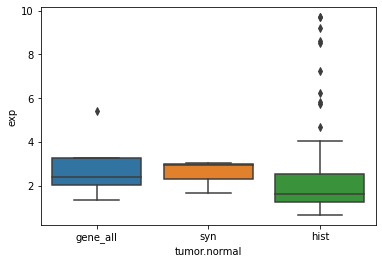

In [116]:
sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)

In [123]:
testStat, pval = mannwhitneyu(gene_test, hist_test)

In [124]:
pval

0.13084995885617695

-----------------------
### Permutation test example

In [19]:
np.random.seed(500)

In [128]:
x= np.array(hist_test['ENSG00000161547.10'].tolist()); y = np.array(syn_test['ENSG00000161547.10'].tolist())
obs_mean_diff = x.mean()-y.mean()
pooled = np.hstack([x,y])

In [129]:
def permutation_test(pool,xsize,ysize):
    permuted = np.random.permutation(pool)
    starX = permuted[:xsize]
    starY = permuted[-ysize:]
    return starX.mean() - starY.mean()

In [130]:
npermute = 10000
lpermute = []
for i in range(npermute):
    lpermute.append(permutation_test(pooled,x.size, y.size))

In [131]:
diffCount = len(np.where(np.array(lpermute>= obs_mean_diff))[0])

In [132]:
float(diffCount)/float(npermute)

0.6913